# Imports

In [60]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(ROOT)

In [61]:
import polars as pl
import matplotlib.pyplot as plt
from src.config import CONFIG

RAW_DATA_PATH = CONFIG.RAW_DATA_PATH
PRO_DATA_PATH_v1 = CONFIG.PRO_DATA_PATH_v1

# Data load and downcast

In [62]:
# def load_raw_data_save(read_path, save_path):
#     df = pl.read_csv(read_path, try_parse_dates=True)

#     df = df.with_columns([
#         pl.col(col).cast(pl.Float32, strict=False) for col in df.columns if col != "Date Time"
#     ])

#     df.sort("Date Time").write_parquet(save_path)

#     return df

# df = load_raw_data_save(RAW_DATA_PATH, PRO_DATA_PATH_v1)

Reload from saved parquet file

In [63]:
df = pl.read_parquet(PRO_DATA_PATH_v1)

In [64]:
def check_data(df):
    print(f"Data shape: {df.shape}")

    missing_values = df.null_count()
    print("\nMissing values per column:")
    print(missing_values)
    print("\nTotal missing values:") 
    print(missing_values.to_numpy()[0].sum())

    min_date = df["Date Time"].min()
    max_date = df["Date Time"].max()
    print(f"\nDate range: {min_date} to {max_date}")

check_data(df)

Data shape: (420551, 15)

Missing values per column:
shape: (1, 15)
┌───────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────────┬──────────┐
│ Date Time ┆ p (mbar) ┆ T (degC) ┆ Tpot (K) ┆ … ┆ rho      ┆ wv (m/s) ┆ max. wv (m/s)  ┆ wd (deg) │
│ ---       ┆ ---      ┆ ---      ┆ ---      ┆   ┆ (g/m**3) ┆ ---      ┆ ---            ┆ ---      │
│ u32       ┆ u32      ┆ u32      ┆ u32      ┆   ┆ ---      ┆ u32      ┆ u32            ┆ u32      │
│           ┆          ┆          ┆          ┆   ┆ u32      ┆          ┆                ┆          │
╞═══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════════╪══════════╡
│ 0         ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 0        ┆ 0        ┆ 0              ┆ 0        │
└───────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────────┴──────────┘

Total missing values:
0

Date range: 2009-01-01 00:10:00 to 2017-01-01 00:00:00


In [65]:
print(df.to_pandas().describe())

                        Date Time       p (mbar)       T (degC)  \
count                      420551  420551.000000  420551.000000   
mean   2012-12-30 06:26:51.498724     989.212952       9.450148   
min           2009-01-01 00:10:00     913.599976     -23.010000   
25%           2010-12-31 03:25:00     984.200012       3.360000   
50%           2012-12-30 06:20:00     989.580017       9.420000   
75%           2014-12-29 18:55:00     994.719971      15.470000   
max           2017-01-01 00:00:00    1015.349976      37.279999   
std                           NaN       8.358480       8.423365   

            Tpot (K)    Tdew (degC)         rh (%)   VPmax (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      283.492737       4.955855      76.008263      13.576251   
min       250.600006     -25.010000      12.950000       0.950000   
25%       277.429993       0.240000      65.209999       7.780000   
50%       283.470001       5.220000      79.300003 

### Correct outliers

In [66]:
# How many negs in to_correct = ['wv (m/s)', 'max. wv (m/s)']

for col in ['wv (m/s)', 'max. wv (m/s)']:
    print(col, df.filter(pl.col(col) < 0).select(col).count().to_numpy()[0])

wv (m/s) [18]
max. wv (m/s) [20]


In [67]:
out_df = df.filter((pl.col("wv (m/s)") < 0) | (pl.col("max. wv (m/s)") < 0))
min_date = out_df["Date Time"].min()
max_date = out_df["Date Time"].max()
print(f"\nDate range: {min_date} to {max_date}")


Date range: 2015-07-13 09:00:00 to 2015-07-13 12:10:00


In [69]:
# Convert to NaN to later impute
df = df.with_columns([
    pl.col("wv (m/s)").replace(-9999, None),
    pl.col("max. wv (m/s)").replace(-9999, None)
])

# Visualize some data

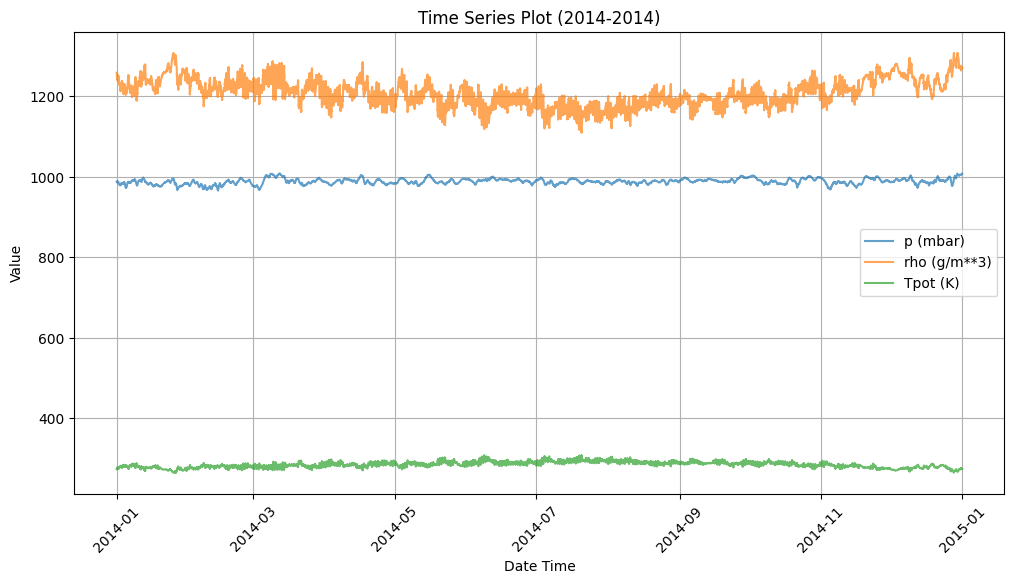

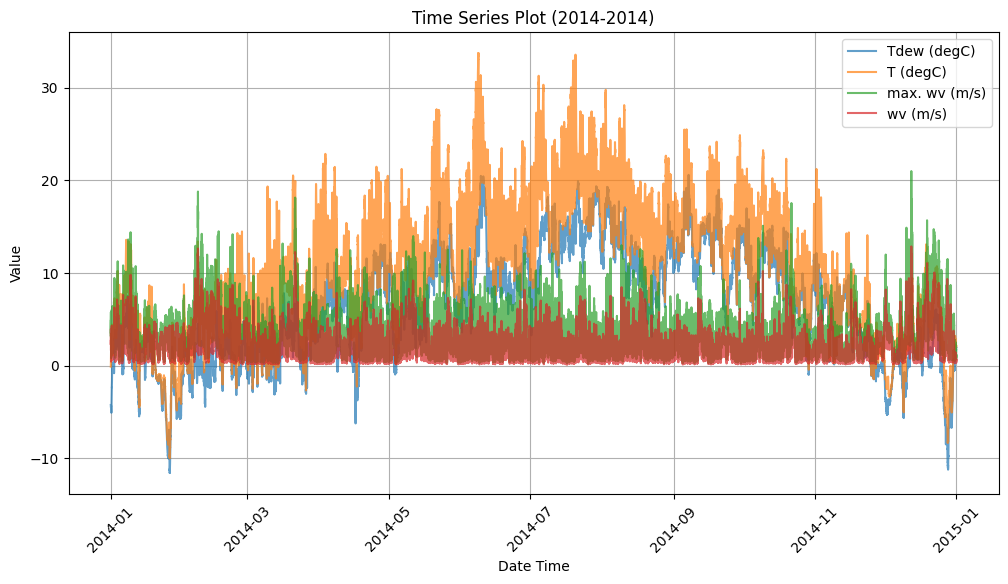

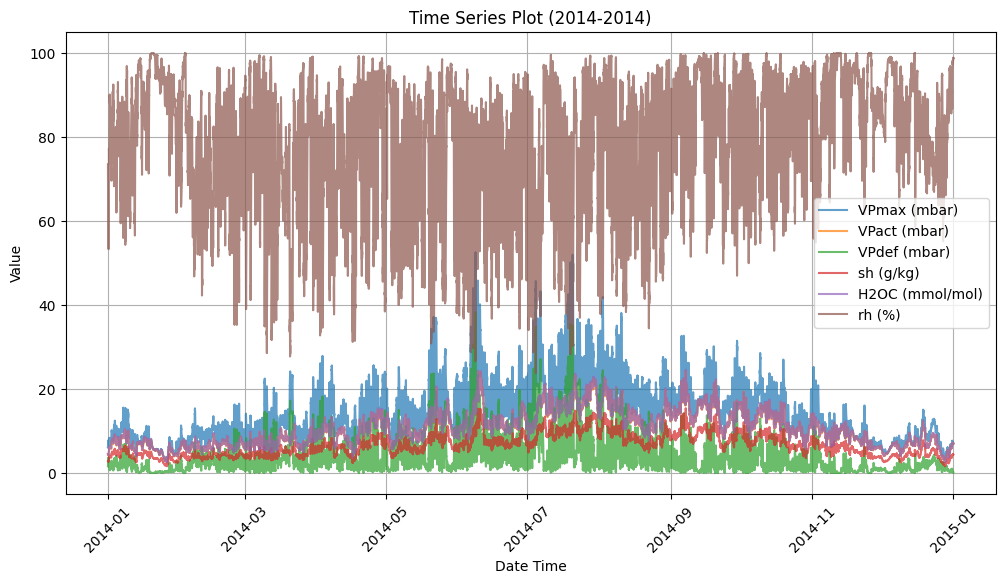

In [84]:
def plot_years(df, year1, year2):

    # Group by ~ scale
    grouped_variables = [
        ["p (mbar)", "rho (g/m**3)","Tpot (K)"],
        ["Tdew (degC)", "T (degC)", "max. wv (m/s)", "wv (m/s)"],
        ["VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rh (%)"]#, "wd (deg)"]
    ]

    filtered_df = df.filter(
        (df["Date Time"].dt.year() >= year1) & (df["Date Time"].dt.year() <= year2)
    )

    if filtered_df.is_empty():
        print(f"No data available for the range {year1}-{year2}.")
        return

    for cols in grouped_variables:

        plt.figure(figsize=(12, 6))
        for col in cols:
            plt.plot(filtered_df["Date Time"], filtered_df[col], label=col, alpha=0.7)

        plt.xlabel("Date Time")
        plt.ylabel("Value")
        plt.title(f"Time Series Plot ({year1}-{year2})")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

plot_years(df, 2014, 2014)

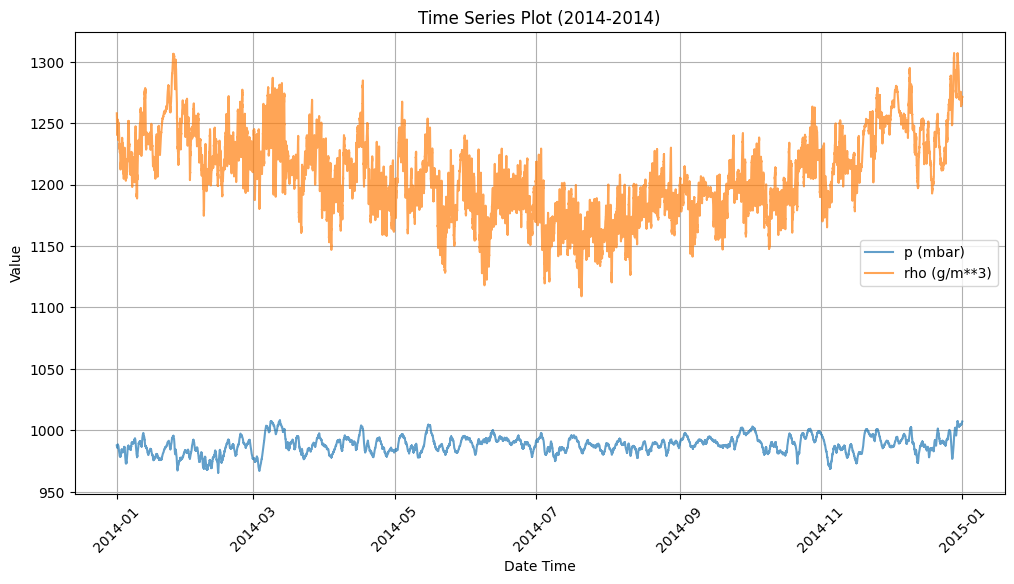

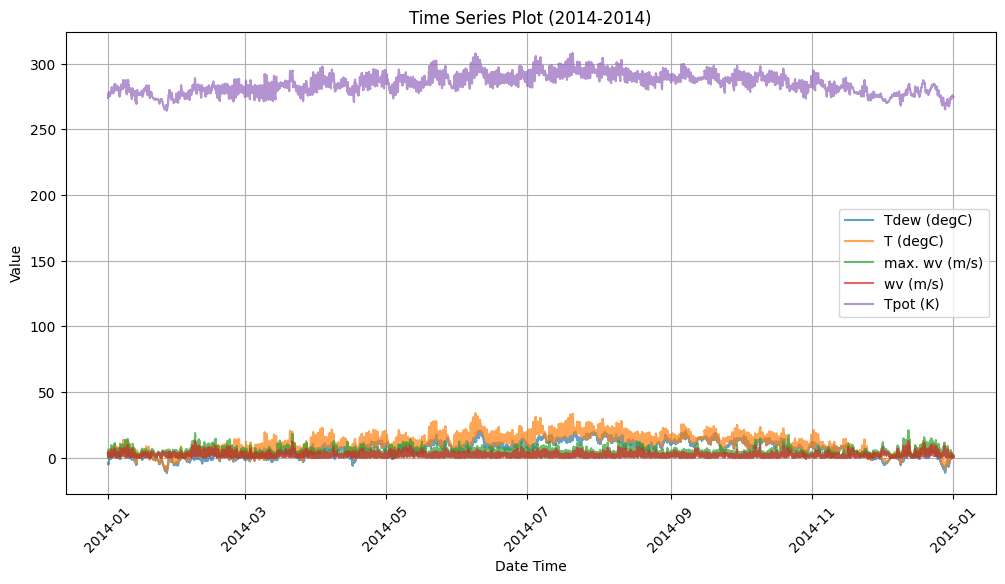

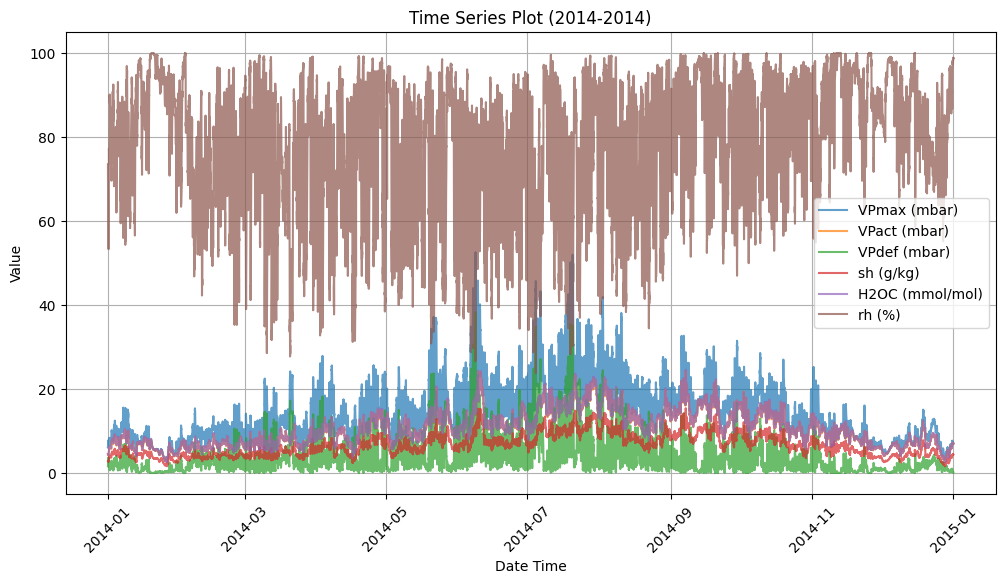

In [81]:
plot_years(df, 2014, 2014)